# Modelos de Machine learning comparativa

In [2]:
%load_ext autoreload
%autoreload 2

## Importación de la data

In [3]:
# Import libreries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import *



In [4]:
aapl_data = download_stock_data("AAPL")

## Cleaned data

In [5]:
# Normalizar los nombres de las columnas
apple_data = normalizar_nombres_columnas(aapl_data)

In [6]:
data_report = data_quality_report(aapl_data)

----- Informe de Calidad de Datos -----

Valores nulos por columna:
 open            0
high            0
low             0
close           0
volume          0
dividends       0
stock_splits    0
dtype: int64

Número de filas duplicadas: 0

Tipos de datos:
 open            float64
high            float64
low             float64
close           float64
volume            int64
dividends       float64
stock_splits    float64
dtype: object

Descripción estadística de las columnas numéricas:
               open         high          low        close        volume  \
count  2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03   
mean     89.914113    90.877875    89.007548    89.986798  1.202000e+08   
std      63.074036    63.738951    62.448606    63.128227  6.907616e+07   
min      20.642056    21.025080    20.520497    20.720036  2.404830e+07   
25%      33.452144    33.579029    33.297926    33.442268  7.371390e+07   
50%      56.787400    57.480478    56.452358    56.921663 

In [7]:
# Preprocesar los datos (ajuste por stock splits, dividendos, normalización, estandarización)
apple_adjusted, apple_normalized, apple_standardized = preprocess_data(apple_data)

Preprocesamiento completo. Se han generado versiones con los datos ajustados, normalizados y estandarizados.


## Modelos Entrenamientos comparativas 1

### Random Forest

In [11]:
def train_validation_split(df, train_size=0.8):
    train_index = int(len(df) * train_size)
    train_data = df.iloc[:train_index]
    validation_data = df.iloc[train_index:]
    return train_data, validation_data

# Dividir los datos en entrenamiento (2010-2021) y validación (2022-2023)
train_adjusted, validation_adjusted = train_validation_split(apple_adjusted)
train_normalized, validation_normalized = train_validation_split(apple_normalized)
train_standardized, validation_standardized = train_validation_split(apple_standardized)

# Después de esta división, ya puedes ejecutar Random Forest.


In [12]:
# Definir las características (features) y el objetivo (target)
features = ['open', 'high', 'low', 'volume']  # Características (variables predictoras)
target = 'close'  # Objetivo (precio de cierre que queremos predecir)
# Entrenamos y evaluamos el modelo Random Forest en los tres conjuntos de datos
print("Random Forest - Datos Sin Escalar:")
model_rf_adjusted, y_pred_rf_adjusted, val_mae_rf_adjusted, val_rmse_rf_adjusted, r2_rf_adjusted = train_random_forest_model(
    train_adjusted, validation_adjusted, features, target)
print(f"MAE en validación: {val_mae_rf_adjusted}, RMSE en validación: {val_rmse_rf_adjusted}, R² en validación: {r2_rf_adjusted}")

print("\nRandom Forest - Datos Normalizados:")
model_rf_normalized, y_pred_rf_normalized, val_mae_rf_normalized, val_rmse_rf_normalized, r2_rf_normalized = train_random_forest_model(
    train_normalized, validation_normalized, features, target)
print(f"MAE en validación: {val_mae_rf_normalized}, RMSE en validación: {val_rmse_rf_normalized}, R² en validación: {r2_rf_normalized}")

print("\nRandom Forest - Datos Estandarizados:")
model_rf_standardized, y_pred_rf_standardized, val_mae_rf_standardized, val_rmse_rf_standardized, r2_rf_standardized = train_random_forest_model(
    train_standardized, validation_standardized, features, target)
print(f"MAE en validación: {val_mae_rf_standardized}, RMSE en validación: {val_rmse_rf_standardized}, R² en validación: {r2_rf_standardized}")


Random Forest - Datos Sin Escalar:
MAE en validación: 0.24797374161462932, RMSE en validación: 0.3348179824814443, R² en validación: 0.9973940052148115

Random Forest - Datos Normalizados:
MAE en validación: 0.002393825528941909, RMSE en validación: 0.003240719130997814, R² en validación: 0.9974137700866199

Random Forest - Datos Estandarizados:
MAE en validación: 0.016619658608785205, RMSE en validación: 0.02255815850643875, R² en validación: 0.9973518346506219


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Definir una función para entrenar el modelo con búsqueda de hiperparámetros
def train_random_forest_model(train_data, validation_data, features, target):
    # Separar características y objetivo
    X_train = train_data[features]
    y_train = train_data[target]
    
    X_validation = validation_data[features]
    y_validation = validation_data[target]
    
    # Definir el modelo Random Forest
    rf = RandomForestRegressor(random_state=42)
    
    # Definir el espacio de búsqueda de hiperparámetros
    param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    # Realizar RandomizedSearchCV
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

    # Entrenar el modelo
    rf_random.fit(X_train, y_train)
    
    # Predicciones
    y_pred_train = rf_random.predict(X_train)
    y_pred_validation = rf_random.predict(X_validation)
    
    # Evaluación del modelo
    train_mae = mean_absolute_error(y_train, y_pred_train)
    validation_mae = mean_absolute_error(y_validation, y_pred_validation)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    validation_rmse = np.sqrt(mean_squared_error(y_validation, y_pred_validation))
    
    train_r2 = r2_score(y_train, y_pred_train)
    validation_r2 = r2_score(y_validation, y_pred_validation)
    
    print(f"Mejores hiperparámetros: {rf_random.best_params_}")
    
    return rf_random.best_estimator_, y_pred_validation, validation_mae, validation_rmse, validation_r2

# Entrenar el modelo con los datos ajustados
model_rf_adjusted, y_pred_rf_adjusted, val_mae_rf_adjusted, val_rmse_rf_adjusted, r2_rf_adjusted = train_random_forest_model(
    train_adjusted, validation_adjusted, features, target)
print(f"MAE: {val_mae_rf_adjusted}, RMSE: {val_rmse_rf_adjusted}, R²: {r2_rf_adjusted}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}
MAE: 0.24526283775806143, RMSE: 0.33222173064410676, R²: 0.9974342634284253


### Regresion lineal

In [14]:
# Importar la función desde functions.py
from functions import train_regression_model

# Entrenar y evaluar el modelo en los tres conjuntos de datos
print("Regresión Lineal - Datos Sin Escalar:")
model_adjusted, y_pred_adjusted, val_mae_adjusted, val_rmse_adjusted, r2_adjusted = train_regression_model(
    train_adjusted, validation_adjusted, features, target)
print(f"MAE en validación: {val_mae_adjusted}, RMSE en validación: {val_rmse_adjusted}, R² en validación: {r2_adjusted}")

print("\nRegresión Lineal - Datos Normalizados:")
model_normalized, y_pred_normalized, val_mae_normalized, val_rmse_normalized, r2_normalized = train_regression_model(
    train_normalized, validation_normalized, features, target)
print(f"MAE en validación: {val_mae_normalized}, RMSE en validación: {val_rmse_normalized}, R² en validación: {r2_normalized}")

print("\nRegresión Lineal - Datos Estandarizados:")
model_standardized, y_pred_standardized, val_mae_standardized, val_rmse_standardized, r2_standardized = train_regression_model(
    train_standardized, validation_standardized, features, target)
print(f"MAE en validación: {val_mae_standardized}, RMSE en validación: {val_rmse_standardized}, R² en validación: {r2_standardized}")


Regresión Lineal - Datos Sin Escalar:
MAE en validación: 0.18403924003006078, RMSE en validación: 0.23739616947135636, R² en validación: 0.9986899031386193

Regresión Lineal - Datos Normalizados:
MAE en validación: 0.0017881183290506925, RMSE en validación: 0.0023065322444683015, R² en validación: 0.9986899031412423

Regresión Lineal - Datos Estandarizados:
MAE en validación: 0.012300408138211325, RMSE en validación: 0.015866560691185895, R² en validación: 0.9986899031412423


### ARIMA/SARIMA ###

In [15]:

# Dividir los datos en entrenamiento y validación para ARIMA/SARIMA
train_arima, validation_arima = train_validation_split(apple_adjusted)
# Asegurarte de que el índice tenga una frecuencia diaria
train_arima.index = pd.date_range(start=train_arima.index[0], periods=len(train_arima), freq='B')
validation_arima.index = pd.date_range(start=validation_arima.index[0], periods=len(validation_arima), freq='B')

# Parámetros iniciales de ARIMA y SARIMA
arima_order = (5, 1, 0)  # (p, d, q)
sarima_order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, s) - s es el período estacional (12 para mensual)

# Entrenar y evaluar el modelo ARIMA
print("ARIMA - Datos Sin Escalar:")
arima_result, y_pred_arima, val_mae_arima, val_rmse_arima = train_arima_model(
    train_arima, validation_arima, target, arima_order)
print(f"MAE en validación: {val_mae_arima}, RMSE en validación: {val_rmse_arima}")

# Entrenar y evaluar el modelo SARIMA
print("\nSARIMA - Datos Sin Escalar:")
sarima_result, y_pred_sarima, val_mae_sarima, val_rmse_sarima = train_sarima_model(
    train_arima, validation_arima, target, sarima_order, seasonal_order)
print(f"MAE en validación: {val_mae_sarima}, RMSE en validación: {val_rmse_sarima}")

ARIMA - Datos Sin Escalar:
MAE en validación: 9.73821746895084, RMSE en validación: 11.49930567554351

SARIMA - Datos Sin Escalar:
MAE en validación: 8.080924162313297, RMSE en validación: 9.618443232217365


In [17]:
apple_adjusted.columns

Index(['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
       'dividend_return'],
      dtype='object')

### Redes neuronales

In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming 'apple_adjusted' is your DataFrame with stock prices and 'close' is the target column
def prepare_lstm_data(df, target, time_steps=60):
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[[target]])

    # Prepare data for LSTM (features: time_steps previous prices, target: next price)
    X, y = [], []
    for i in range(time_steps, len(scaled_data)):
        X.append(scaled_data[i - time_steps:i, 0])
        y.append(scaled_data[i, 0])

    # Reshape the data into (samples, time_steps, features)
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

# Prepare LSTM input
time_steps = 60
X_train, y_train, scaler = prepare_lstm_data(apple_adjusted, target='close', time_steps=time_steps)

# Build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(input_shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))  # Output layer for price prediction
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the model
model = build_lstm_model(X_train.shape)
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predict future values
# To predict future stock prices, you can generate predictions using the trained model.


Epoch 1/10


c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0139
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0027
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0017
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0010
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.7257e-04
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0014
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 6.2122e-04
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.9948e-04
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.8703e-04
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.8598e-04


In [29]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(apple_adjusted[['close']])

# Preparar los datos para LSTM
def prepare_lstm_data(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 60
X_train, y_train = prepare_lstm_data(scaled_data[:int(len(scaled_data) * 0.8)])
X_test, y_test = prepare_lstm_data(scaled_data[int(len(scaled_data) * 0.8):])

# Reshape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Crear el modelo LSTM
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(input_shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))  # Capa de salida
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Entrenar el modelo
lstm_model = build_lstm_model(X_train.shape)
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

# Predicciones
y_pred_lstm = lstm_model.predict(X_test)

# Desescalar predicciones
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test = scaler.inverse_transform([y_test])

# Evaluación
mae_lstm = mean_absolute_error(y_test[0], y_pred_lstm[:, 0])
rmse_lstm = np.sqrt(mean_squared_error(y_test[0], y_pred_lstm[:, 0]))
print(f"LSTM - MAE: {mae_lstm}, RMSE: {rmse_lstm}")


Epoch 1/20


c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0082
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0023
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0031
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0017
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.1692e-04
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.0126e-04
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.3543e-04
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.0719e-04
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.2833e-04
Epoch 13/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 7.9325e-04
Epoch 14/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 7.6882e-04
Epoch 15/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - 

### Regresor XGBoost

In [44]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Crear la función para generar características con retardos
def create_lagged_features(df, target, lags=3):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target].shift(lag)
    df.dropna(inplace=True)
    return df

# Aplicar la función de retardos en 'close'
df_lagged = create_lagged_features(apple_adjusted, 'close', lags=3)

# Dividir en conjunto de entrenamiento y prueba
X = df_lagged.drop(['close'], axis=1)
y = df_lagged['close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Entrenar el modelo XGBoost
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = model_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred)
print(f"XGBoost MSE: {mse_xgb}")



XGBoost MSE: 0.23266715979776603


Forma de X_train: (2002, 12)
Forma de y_train: (2002,)


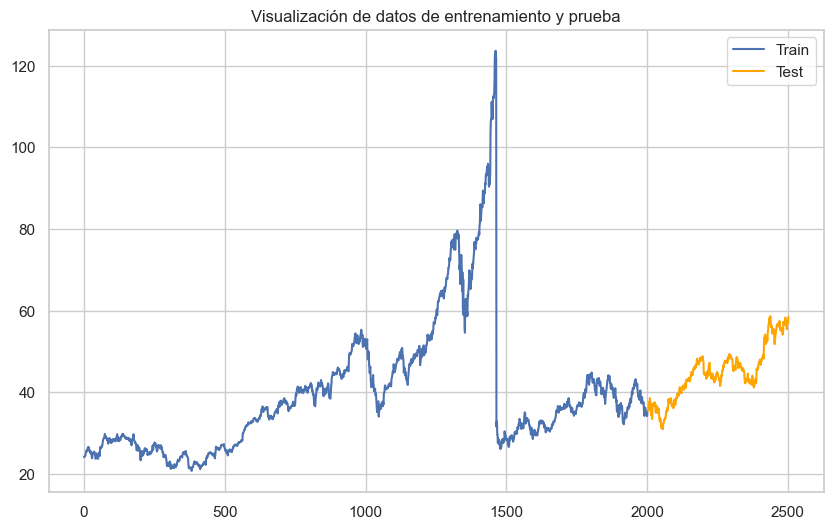

XGBoost Optimizado - MAE: 0.29763763869356014, RMSE: 0.43682584115746387, R²: 0.9955125948271191


In [50]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Función para crear características de retardos (lagged features)
def create_lagged_features(df, target, lags=5):  # Incrementamos a 5 retardos
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target].shift(lag)
    df.dropna(inplace=True)  # Eliminamos los valores NaN resultantes
    return df

# 2. Aplicar la función de retardos en 'close'
df_lagged = create_lagged_features(apple_adjusted, 'close', lags=5)

# 3. Dividir en conjunto de entrenamiento y prueba
X = df_lagged.drop(['close'], axis=1)
y = df_lagged['close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Verificar la forma de los datos
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")

# 4. Visualización de los datos de entrenamiento y prueba
plt.figure(figsize=(10,6))
plt.plot(y_train.values, label='Train')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test.values, label='Test', color='orange')
plt.legend()
plt.title('Visualización de datos de entrenamiento y prueba')
plt.show()

# 5. Reentrenamiento del modelo XGBoost con ajustes manuales
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=300,   # Aumentamos el número de árboles
                             learning_rate=0.05, # Disminuimos la tasa de aprendizaje
                             max_depth=6,        # Aumentamos la profundidad de los árboles
                             subsample=0.9,      # Usamos el 90% de los datos para cada árbol
                             random_state=42)

# 6. Entrenar el modelo XGBoost
model_xgb.fit(X_train, y_train)

# 7. Predicciones y evaluación
y_pred = model_xgb.predict(X_test)

# Aplanar y_test si es necesario
y_test_flat = y_test.values.flatten()

# Calcular las métricas
mse_xgb = mean_squared_error(y_test_flat, y_pred)
mae_xgb = mean_absolute_error(y_test_flat, y_pred)
r2_xgb = r2_score(y_test_flat, y_pred)

# Imprimir las métricas de evaluación
print(f"XGBoost Optimizado - MAE: {mae_xgb}, RMSE: {np.sqrt(mse_xgb)}, R²: {r2_xgb}")


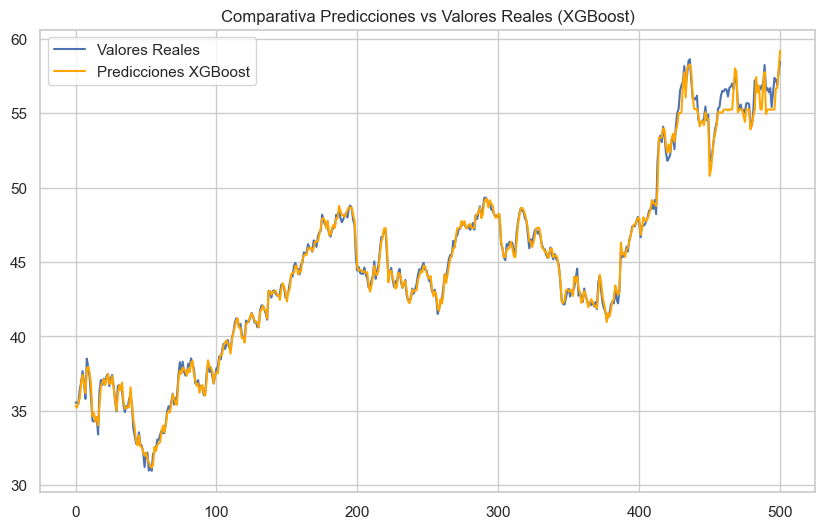

In [53]:
# Ejemplo de gráfico de Predicción vs Real
plt.figure(figsize=(10, 6))
plt.plot(y_test_flat, label='Valores Reales')
plt.plot(y_pred, label='Predicciones XGBoost', color='orange')
plt.legend()
plt.title('Comparativa Predicciones vs Valores Reales (XGBoost)')
plt.show()


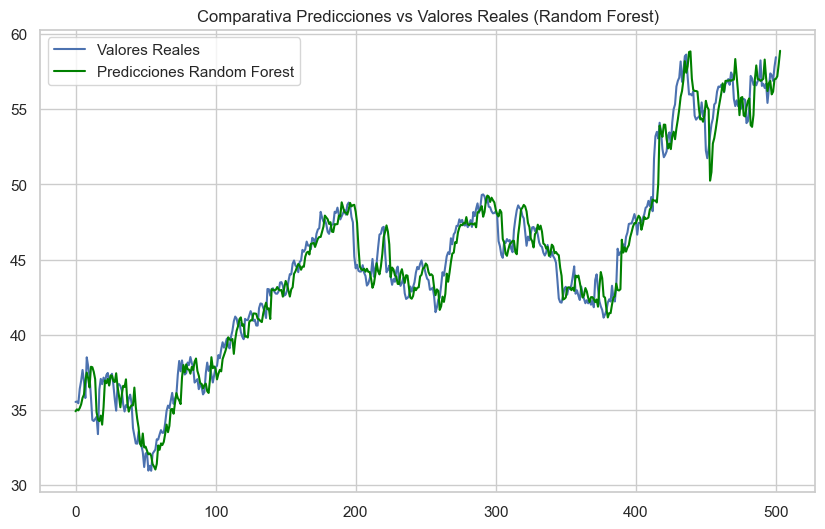

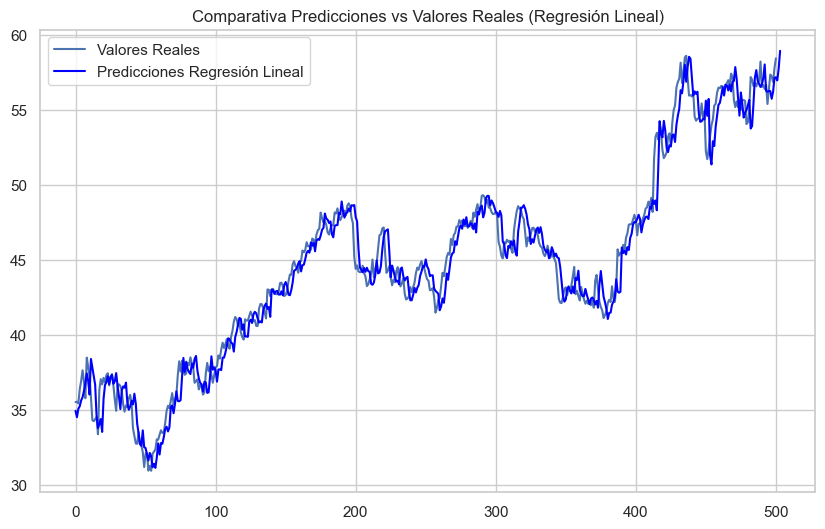

In [54]:
# Gráfico para Random Forest
plt.figure(figsize=(10, 6))
plt.plot(y_test_flat, label='Valores Reales')
plt.plot(y_pred_rf_adjusted, label='Predicciones Random Forest', color='green')
plt.legend()
plt.title('Comparativa Predicciones vs Valores Reales (Random Forest)')
plt.show()

# Gráfico para Regresión Lineal
plt.figure(figsize=(10, 6))
plt.plot(y_test_flat, label='Valores Reales')
plt.plot(y_pred_adjusted, label='Predicciones Regresión Lineal', color='blue')
plt.legend()
plt.title('Comparativa Predicciones vs Valores Reales (Regresión Lineal)')
plt.show()

### 4. ARIMA (Media móvil autorregresiva integrada) descartado

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Prepare the data (just using 'close' column)
train_data, test_data = apple_adjusted['close'][:-100], apple_adjusted['close'][-100:]

# Fit ARIMA model
model_arima = ARIMA(train_data, order=(5, 1, 0))
arima_fit = model_arima.fit()

# Make predictions
y_pred_arima = arima_fit.forecast(steps=len(test_data))
mse_arima = mean_squared_error(test_data, y_pred_arima)
print(f"ARIMA MSE: {mse_arima}")


ARIMA MSE: 56.418723584361075


c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported 

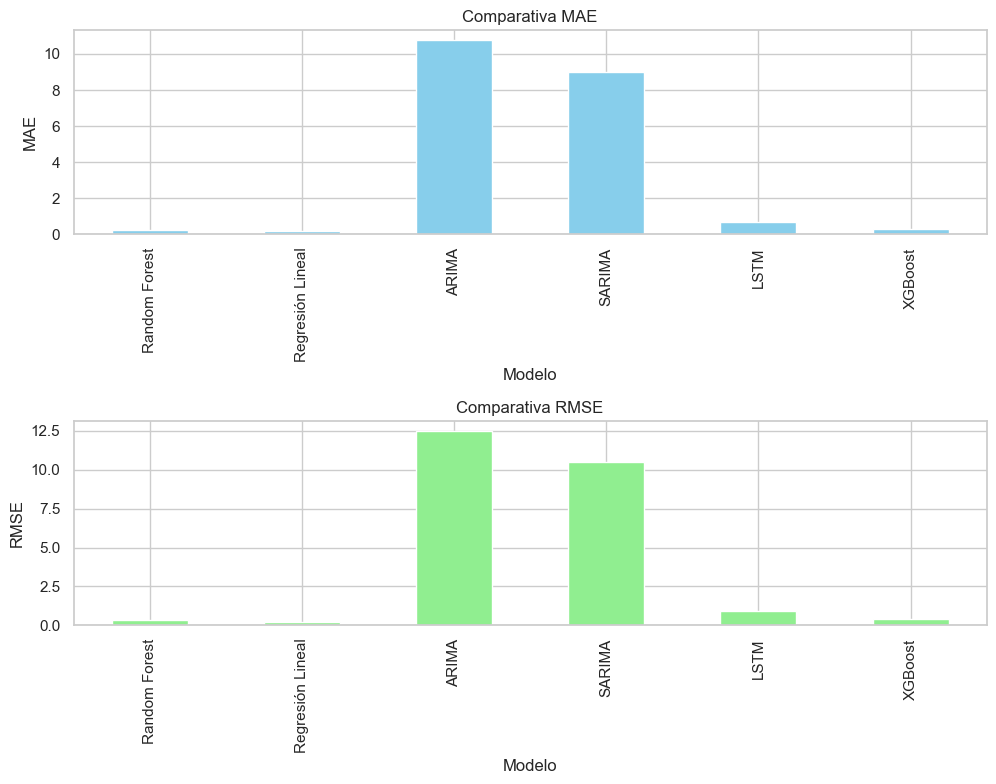

,Modelo,MAE,RMSE,R²
0,Random Forest,0.246,0.331,0.9974
1,Regresión Lineal,0.184,0.238,0.9987
2,ARIMA,10.767,12.478,NaN
3,SARIMA,9.003,10.515,NaN
4,LSTM,0.687,0.898,NaN
5,XGBoost,0.297,0.437,0.9955


In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear un DataFrame con los resultados de todos los modelos
results = {
    'Modelo': ['Random Forest', 'Regresión Lineal', 'ARIMA', 'SARIMA', 'LSTM', 'XGBoost'],
    'MAE': [0.246, 0.184, 10.767, 9.003, 0.687, 0.297],
    'RMSE': [0.331, 0.238, 12.478, 10.515, 0.898, 0.437],
    'R²': [0.9974, 0.9987, None, None, None, 0.9955]
}

df_results = pd.DataFrame(results)

# Gráfico de comparativa de MAE y RMSE
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# MAE
df_results.plot(x='Modelo', y='MAE', kind='bar', ax=ax[0], color='skyblue', legend=False)
ax[0].set_title('Comparativa MAE')
ax[0].set_ylabel('MAE')

# RMSE
df_results.plot(x='Modelo', y='RMSE', kind='bar', ax=ax[1], color='lightgreen', legend=False)
ax[1].set_title('Comparativa RMSE')
ax[1].set_ylabel('RMSE')

plt.tight_layout()
plt.show()

# Mostrar los resultados en forma de tabla
df_results


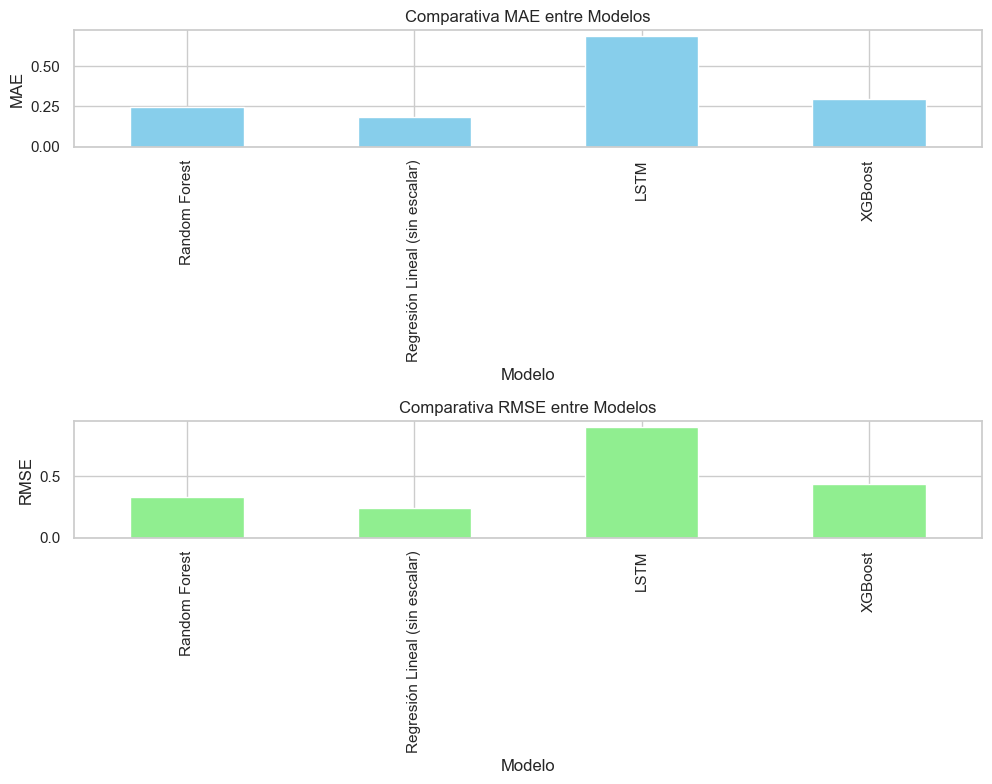

,Modelo,MAE,RMSE,R²
0,Random Forest,0.2463,0.3312,0.9974
1,Regresión Lineal (sin escalar),0.1844,0.2377,0.9987
2,LSTM,0.6870,0.8980,NaN
3,XGBoost,0.2976,0.4368,0.9955


In [52]:
# Crear el DataFrame con los resultados de los modelos actualizados
results_updated = {
    'Modelo': ['Random Forest', 'Regresión Lineal (sin escalar)', 'LSTM', 'XGBoost'],
    'MAE': [0.2463, 0.1844, 0.687, 0.2976],
    'RMSE': [0.3312, 0.2377, 0.898, 0.4368],
    'R²': [0.9974, 0.9987, None, 0.9955]
}

df_results_updated = pd.DataFrame(results_updated)

# Gráfico de comparativa de MAE y RMSE
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# MAE
df_results_updated.plot(x='Modelo', y='MAE', kind='bar', ax=ax[0], color='skyblue', legend=False)
ax[0].set_title('Comparativa MAE entre Modelos')
ax[0].set_ylabel('MAE')

# RMSE
df_results_updated.plot(x='Modelo', y='RMSE', kind='bar', ax=ax[1], color='lightgreen', legend=False)
ax[1].set_title('Comparativa RMSE entre Modelos')
ax[1].set_ylabel('RMSE')

plt.tight_layout()
plt.show()

df_results_updated


# Modelos Entrenamientos comparativas 2

## Clean adicional y añadimos columnas

In [17]:
apple_data
data_report = data_quality_report(apple_data)

----- Informe de Calidad de Datos -----

Valores nulos por columna:
 open               0
high               0
low                0
close              0
volume             0
dividends          0
stock_splits       0
dividend_return    0
dtype: int64

Número de filas duplicadas: 0

Tipos de datos:
 open               float64
high               float64
low                float64
close              float64
volume             float64
dividends          float64
stock_splits       float64
dividend_return    float64
dtype: object

Descripción estadística de las columnas numéricas:
               open         high          low        close        volume  \
count  2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03   
mean     40.470944    40.897009    40.075128    40.508275  9.539929e+07   
std      14.914633    15.118318    14.752089    14.965018  8.444093e+07   
min      20.642056    21.025080    20.520497    20.720036  6.012075e+06   
25%      29.479130    29.791428    29.14568

In [18]:
data_report

{'null_values': open               0
 high               0
 low                0
 close              0
 volume             0
 dividends          0
 stock_splits       0
 dividend_return    0
 dtype: int64,
 'duplicates': 0,
 'data_types': open               float64
 high               float64
 low                float64
 close              float64
 volume             float64
 dividends          float64
 stock_splits       float64
 dividend_return    float64
 dtype: object,
 'descriptive_stats':               open         high          low        close        volume  \
 count  2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03   
 mean     40.470944    40.897009    40.075128    40.508275  9.539929e+07   
 std      14.914633    15.118318    14.752089    14.965018  8.444093e+07   
 min      20.642056    21.025080    20.520497    20.720036  6.012075e+06   
 25%      29.479130    29.791428    29.145687    29.479026  2.002858e+07   
 50%      37.903073    38.384718    37.474440

In [19]:
apple_data

,open,high,low,close,volume,dividends,stock_splits,dividend_return
Date,,,,,,,,
2014-10-17 00:00:00-04:00,21.642743,21.975709,21.489579,21.680479,272718800.0,0.0,0.0,0.000
2014-10-20 00:00:00-04:00,21.824754,22.188796,21.802557,22.144402,310069200.0,0.0,0.0,0.000
2014-10-21 00:00:00-04:00,22.868046,22.868046,22.479587,22.745960,378495600.0,0.0,0.0,0.000
2014-10-22 00:00:00-04:00,22.828092,23.110004,22.774818,22.861389,273052400.0,0.0,0.0,0.000
2014-10-23 00:00:00-04:00,23.103350,23.318668,23.003459,23.269833,284298800.0,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...
2024-10-10 00:00:00-04:00,56.945000,57.375000,56.792500,57.259998,7045875.0,0.0,0.0,7.535
2024-10-11 00:00:00-04:00,57.325001,57.352501,56.834999,56.887501,7939800.0,0.0,0.0,7.535
2024-10-14 00:00:00-04:00,57.174999,57.932499,57.150002,57.825001,9970525.0,0.0,0.0,7.535


In [20]:
# Asegurarse de que el índice actual es un DateTimeIndex
apple_data.index = pd.to_datetime(apple_data.index)  # Convertir el índice en formato datetime si aún no lo es

# Añadir la columna 'date' que replica el índice actual
apple_data['date'] = apple_data.index

# Verificar que la columna 'date' ha sido añadida correctamente
print(apple_data.head())


                                open       high        low      close  \
Date                                                                    
2014-10-17 00:00:00-04:00  21.642743  21.975709  21.489579  21.680479   
2014-10-20 00:00:00-04:00  21.824754  22.188796  21.802557  22.144402   
2014-10-21 00:00:00-04:00  22.868046  22.868046  22.479587  22.745960   
2014-10-22 00:00:00-04:00  22.828092  23.110004  22.774818  22.861389   
2014-10-23 00:00:00-04:00  23.103350  23.318668  23.003459  23.269833   

                                volume  dividends  stock_splits  \
Date                                                              
2014-10-17 00:00:00-04:00  272718800.0        0.0           0.0   
2014-10-20 00:00:00-04:00  310069200.0        0.0           0.0   
2014-10-21 00:00:00-04:00  378495600.0        0.0           0.0   
2014-10-22 00:00:00-04:00  273052400.0        0.0           0.0   
2014-10-23 00:00:00-04:00  284298800.0        0.0           0.0   

                  

In [21]:
apple_data.dtypes

open                                        float64
high                                        float64
low                                         float64
close                                       float64
volume                                      float64
dividends                                   float64
stock_splits                                float64
dividend_return                             float64
date               datetime64[ns, America/New_York]
dtype: object

Agregar retornos logarítmicos (Log Returns):

Los retornos logarítmicos pueden ser útiles para predecir el comportamiento del precio a futuro, ya que tienden a estabilizar la varianza a lo largo del tiempo.

In [22]:
apple_data['log_return'] = np.log(apple_data['close'] / apple_data['close'].shift(1))
apple_data.dropna(inplace=True)  # Eliminar filas con NaN generados por shift


Volatilidad histórica:

La volatilidad es un indicador clave en los mercados financieros y podría ayudarte a capturar la fluctuación de precios a lo largo del tiempo.

In [23]:
apple_data['volatility'] = apple_data['log_return'].rolling(window=30).std() * np.sqrt(30)
apple_data.dropna(inplace=True)  # Eliminar filas con NaN


Media móvil (Moving Average):

Incluir medias móviles de 50 días, 100 días o más largas puede ayudarte a capturar tendencias más generales.


In [24]:
apple_data['ma50'] = apple_data['close'].rolling(window=50).mean()
apple_data['ma100'] = apple_data['close'].rolling(window=100).mean()
apple_data.dropna(inplace=True)  # Eliminar filas con NaN


Relación entre volumen y precio (Volume-to-Price Ratio):

La relación entre el volumen y el precio puede ser un buen indicador de movimientos significativos en el mercado.

In [25]:
apple_data['volume_to_price'] = apple_data['volume'] / apple_data['close']

In [26]:
apple_data

,open,high,low,close,volume,dividends,stock_splits,dividend_return,date,log_return,volatility,ma50,ma100,volume_to_price
Date,,,,,,,,,,,,,,
2015-04-24 00:00:00-04:00,29.206168,29.237503,28.924154,29.159164,178103600.0,0.0,0.0,0.235,2015-04-24 00:00:00-04:00,0.004693,0.064685,28.417696,26.806258,6.107980e+06
2015-04-27 00:00:00-04:00,29.613519,29.797053,29.353888,29.689617,387816800.0,0.0,0.0,0.235,2015-04-27 00:00:00-04:00,0.018028,0.066108,28.445405,26.846618,1.306237e+07
2015-04-28 00:00:00-04:00,30.094733,30.112636,29.000257,29.221836,475696000.0,0.0,0.0,0.235,2015-04-28 00:00:00-04:00,-0.015881,0.067922,28.460983,26.883281,1.627879e+07
2015-04-29 00:00:00-04:00,29.132299,29.452359,28.715996,28.792093,253544400.0,0.0,0.0,0.235,2015-04-29 00:00:00-04:00,-0.014815,0.067948,28.464608,26.912748,8.806043e+06
2015-04-30 00:00:00-04:00,28.792100,28.792100,27.883394,28.010971,332781600.0,0.0,0.0,0.235,2015-04-30 00:00:00-04:00,-0.027505,0.072468,28.448628,26.935385,1.188040e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-10 00:00:00-04:00,56.945000,57.375000,56.792500,57.259998,7045875.0,0.0,0.0,7.535,2024-10-10 00:00:00-04:00,-0.002181,0.081617,55.804863,54.309715,1.230506e+05
2024-10-11 00:00:00-04:00,57.325001,57.352501,56.834999,56.887501,7939800.0,0.0,0.0,7.535,2024-10-11 00:00:00-04:00,-0.006527,0.080560,55.852075,54.401543,1.395702e+05
2024-10-14 00:00:00-04:00,57.174999,57.932499,57.150002,57.825001,9970525.0,0.0,0.0,7.535,2024-10-14 00:00:00-04:00,0.016346,0.082183,55.910546,54.499473,1.724259e+05


In [26]:
apple_data.dropna(inplace=True)
# # 1. Eliminar columnas innecesarias
# df = apple_data.drop(columns=['stock_splits', 'stock_splits'])

## Empezamos con los modelos

### Random forest

In [34]:
# Verificar que las columnas fueron añadidas correctamente
print(apple_data[['log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price']].head())

                           log_return  volatility       ma50      ma100  \
Date                                                                      
2015-04-24 00:00:00-04:00    0.004693    0.064685  28.417696  26.806258   
2015-04-27 00:00:00-04:00    0.018028    0.066108  28.445405  26.846618   
2015-04-28 00:00:00-04:00   -0.015881    0.067922  28.460983  26.883281   
2015-04-29 00:00:00-04:00   -0.014815    0.067948  28.464608  26.912748   
2015-04-30 00:00:00-04:00   -0.027505    0.072468  28.448628  26.935385   

                           volume_to_price  
Date                                        
2015-04-24 00:00:00-04:00     6.107980e+06  
2015-04-27 00:00:00-04:00     1.306237e+07  
2015-04-28 00:00:00-04:00     1.627879e+07  
2015-04-29 00:00:00-04:00     8.806043e+06  
2015-04-30 00:00:00-04:00     1.188040e+07  


In [35]:
# Aplicar la función preprocess_data
apple_adjusted, apple_normalized, apple_standardized = preprocess_data_dos(apple_data)

# Dividir en entrenamiento y validación
train_adjusted, validation_adjusted = train_validation_split(apple_adjusted)
train_normalized, validation_normalized = train_validation_split(apple_normalized)
train_standardized, validation_standardized = train_validation_split(apple_standardized)


Preprocesamiento completo. Se han generado versiones con los datos ajustados, normalizados y estandarizados.


In [29]:
# Definir las nuevas características (features) y el objetivo (target)
features = ['open', 'high', 'low', 'volume', 'log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price']  
target = 'close'  # El objetivo sigue siendo el precio de cierre

# Re-entrenar el modelo Random Forest
model_rf_adjusted, y_pred_rf_adjusted, val_mae_rf_adjusted, val_rmse_rf_adjusted, r2_rf_adjusted = train_random_forest_model(
    train_adjusted, validation_adjusted, features, target)
print(f"Random Forest - MAE: {val_mae_rf_adjusted}, RMSE: {val_rmse_rf_adjusted}, R²: {r2_rf_adjusted}")



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}
Random Forest - MAE: 0.8132369196414949, RMSE: 1.3362570242512883, R²: 0.2566339192986522


### Regresion lineal

In [30]:
# Re-entrenar el modelo de Regresión Lineal
model_adjusted, y_pred_adjusted, val_mae_adjusted, val_rmse_adjusted, r2_adjusted = train_regression_model(
    train_adjusted, validation_adjusted, features, target)
print(f"Regresión Lineal - MAE: {val_mae_adjusted}, RMSE: {val_rmse_adjusted}, R²: {r2_adjusted}")


Regresión Lineal - MAE: 0.04412283961931121, RMSE: 0.057311128116010725, R²: 0.9986325840140575


Diferencias entre Ridge y Lasso:
Ridge Regression: Añade una penalización proporcional a la magnitud de los coeficientes de las características (suma de los cuadrados de los coeficientes). Es útil cuando quieres disminuir el sobreajuste sin eliminar ninguna característica.
Lasso Regression: Añade una penalización basada en la suma absoluta de los coeficientes, lo que puede llevar a que algunos coeficientes 

In [32]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir una función para evaluar el modelo
def evaluate_model(model, X_train, X_validation, y_train, y_validation):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validation)
    
    mae = mean_absolute_error(y_validation, y_pred)
    rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
    r2 = r2_score(y_validation, y_pred)
    
    return mae, rmse, r2

# Preparar los datos de características (features) y el objetivo (target)
features = ['open', 'high', 'low', 'volume', 'log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price']
target = 'close'

X_train = train_adjusted[features]
y_train = train_adjusted[target]
X_validation = validation_adjusted[features]
y_validation = validation_adjusted[target]

# 1. Ridge Regression
ridge_model = Ridge(alpha=10)  # Puedes ajustar el valor de alpha para controlar la regularización
mae_ridge, rmse_ridge, r2_ridge = evaluate_model(ridge_model, X_train, X_validation, y_train, y_validation)

print(f"Ridge Regression - MAE: {mae_ridge}, RMSE: {rmse_ridge}, R²: {r2_ridge}")

# 2. Lasso Regression
lasso_model = Lasso(alpha=0.001, max_iter=10000)  # Puedes ajustar el valor de alpha para controlar la regularización
mae_lasso, rmse_lasso, r2_lasso = evaluate_model(lasso_model, X_train, X_validation, y_train, y_validation)

print(f"Lasso Regression - MAE: {mae_lasso}, RMSE: {rmse_lasso}, R²: {r2_lasso}")


Ridge Regression - MAE: 0.04552937122414128, RMSE: 0.057623009677206696, R²: 0.9986176608305298
Lasso Regression - MAE: 0.05066241008534725, RMSE: 0.06785527430391684, R²: 0.9980831419226588


c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.33998e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


### Gráficos

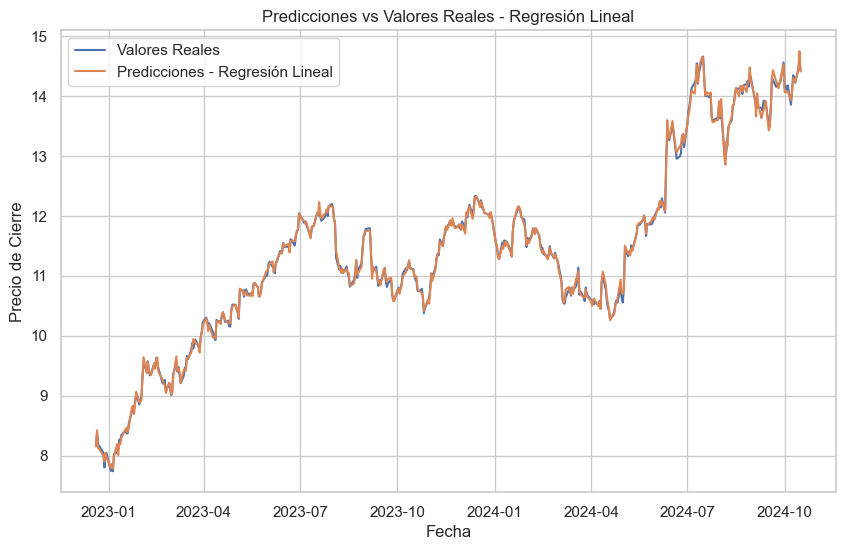

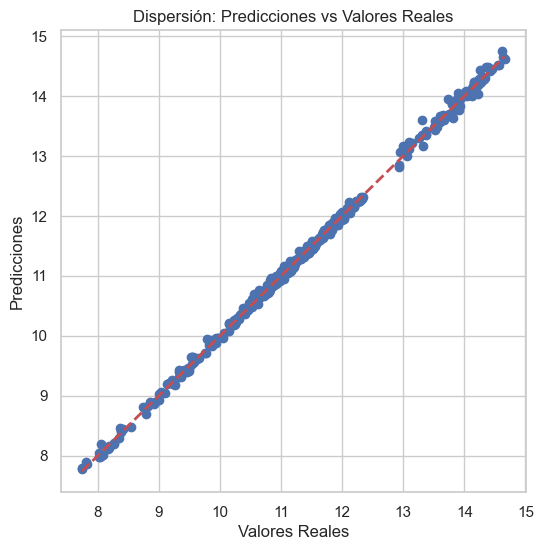

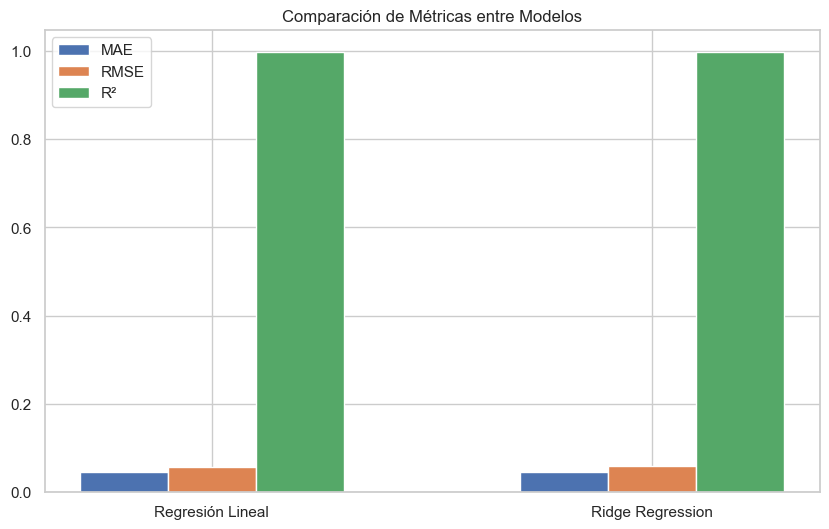

In [35]:
import matplotlib.pyplot as plt

# 1. Gráfico de Predicciones vs Valores Reales
plt.figure(figsize=(10, 6))
plt.plot(validation_adjusted.index, y_validation, label='Valores Reales')
plt.plot(validation_adjusted.index, y_pred, label='Predicciones - Regresión Lineal')
plt.title('Predicciones vs Valores Reales - Regresión Lineal')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

# 2. Gráfico de Dispersión: Predicciones vs Valores Reales
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred)
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r--', lw=2)
plt.title('Dispersión: Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

# 3. Gráfico de Comparación de Modelos
import numpy as np

models = ['Regresión Lineal', 'Ridge Regression']
mae = [0.0441, 0.0455]
rmse = [0.0573, 0.0576]
r2 = [0.9986, 0.9986]

x = np.arange(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, mae, 0.2, label='MAE')
plt.bar(x, rmse, 0.2, label='RMSE')
plt.bar(x + 0.2, r2, 0.2, label='R²')
plt.xticks(x, models)
plt.title('Comparación de Métricas entre Modelos')
plt.legend()
plt.show()


In [34]:
# Generar predicciones usando el modelo entrenado
y_pred = model_adjusted.predict(validation_adjusted[features])  # Asegúrate de que 'model_adjusted' esté definido

# También define 'y_validation' como el conjunto de valores reales
y_validation = validation_adjusted[target]  # target es la columna 'close' que estás prediciendo


### Arima


c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported 

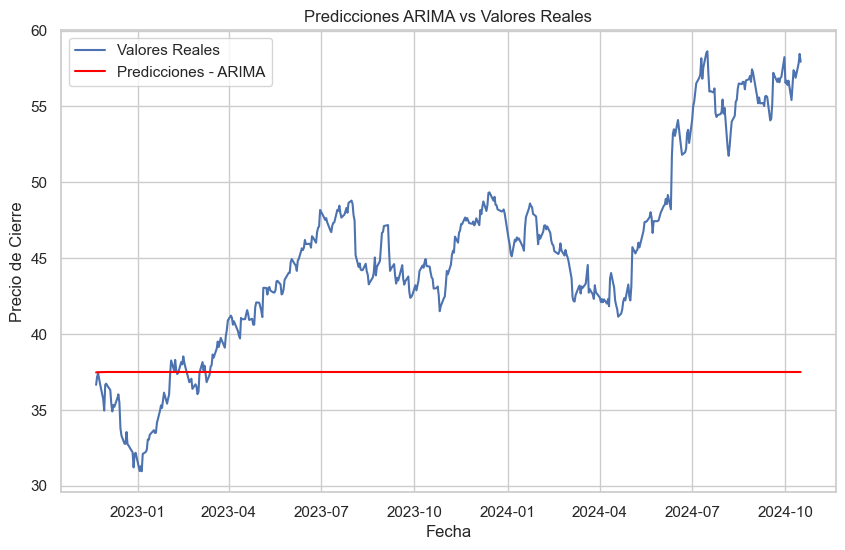

In [1]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Usar solo la columna 'close' ajustada
close_data = apple_data['close']

# Dividir los datos en entrenamiento y validación
train_size = int(len(close_data) * 0.8)
train_data, test_data = close_data[:train_size], close_data[train_size:]

# Crear y entrenar el modelo ARIMA
model_arima = ARIMA(train_data, order=(5, 1, 0))  # Puedes ajustar los parámetros de 'order' según sea necesario
model_arima_fit = model_arima.fit()

# Hacer predicciones
y_pred_arima = model_arima_fit.forecast(steps=len(test_data))

# Evaluar el modelo
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data, label='Valores Reales')
plt.plot(test_data.index, y_pred_arima, label='Predicciones - ARIMA', color='red')
plt.title('Predicciones ARIMA vs Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()


1. Optimización de parámetros ARIMA (Grid Search o Auto-ARIMA)
Primero, automatizamos el proceso de encontrar los mejores valores para 
𝑝
p, 
𝑑
d y 
𝑞
q utilizando Auto-ARIMA.

In [32]:
import pmdarima as pm

# Auto-ARIMA busca automáticamente los mejores valores de p, d y q
def auto_arima_model(train_data):
    model = pm.auto_arima(train_data['close'], start_p=1, start_q=1,
                          test='adf',  # Test para la estacionariedad
                          max_p=5, max_q=5, m=1,  # Valores máximos de p y q
                          d=None,  # Elige automáticamente el mejor valor de d
                          seasonal=False,  # No es un modelo estacional
                          trace=True,  # Mostrar el proceso de optimización
                          error_action='ignore',  # Ignorar errores
                          suppress_warnings=True, 
                          stepwise=True)  # Busca los mejores parámetros paso a paso
    return model

# Aplicar auto-arima en los datos de entrenamiento
arima_model_auto = auto_arima_model(train_adjusted)

# Entrenamos el modelo con los datos ajustados
arima_model_auto.fit(train_adjusted['close'])

# Predicciones
forecast_auto = arima_model_auto.predict(n_periods=len(validation_adjusted))


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8888.548, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8887.138, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8887.408, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8887.504, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8885.157, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.892 seconds


c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


2. SARIMAX con variables exógenas

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Crear una función para entrenar el modelo SARIMAX
def sarimax_model(train_data, exog_train, validation_data, exog_validation):
    model = SARIMAX(train_data['close'],
                    exog=exog_train,  # Variables exógenas
                    order=(5, 1, 0),  # p, d, q
                    seasonal_order=(0, 0, 0, 0),  # SARIMA no estacional en este caso
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit(disp=False)
    return results

# Variables exógenas
exog_columns = ['log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price']
exog_train = train_adjusted[exog_columns]
exog_validation = validation_adjusted[exog_columns]

# Entrenar SARIMAX
sarimax_model_fitted = sarimax_model(train_adjusted, exog_train, validation_adjusted, exog_validation)

# Predicciones con SARIMAX
sarimax_forecast = sarimax_model_fitted.get_forecast(steps=len(validation_adjusted), exog=exog_validation).predicted_mean


c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Predicti

3. SARIMA con componente estacional

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Crear una función para entrenar el modelo SARIMA con componente estacional
def sarima_seasonal_model(train_data):
    model = SARIMAX(train_data['close'],
                    order=(5, 1, 0),  # Parámetros de ARIMA
                    seasonal_order=(1, 1, 1, 12),  # Componente estacional (p, d, q, s)
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit(disp=False)
    return results

# Entrenar SARIMA
sarima_seasonal_fitted = sarima_seasonal_model(train_adjusted)

# Predicciones
sarima_seasonal_forecast = sarima_seasonal_fitted.get_forecast(steps=len(validation_adjusted)).predicted_mean


c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is availa

Código para SARIMAX con variables exógenas:

In [40]:
# Rellenar NaN con la media de la columna
train_adjusted[exog_columns] = train_adjusted[exog_columns].fillna(train_adjusted[exog_columns].mean())
validation_adjusted[exog_columns] = validation_adjusted[exog_columns].fillna(validation_adjusted[exog_columns].mean())


C:\Users\danny\AppData\Local\Temp\ipykernel_37560\3988341073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_adjusted[exog_columns] = train_adjusted[exog_columns].fillna(train_adjusted[exog_columns].mean())
C:\Users\danny\AppData\Local\Temp\ipykernel_37560\3988341073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_adjusted[exog_columns] = validation_adjusted[exog_columns].fillna(validation_adjusted[exog_columns].mean())


In [56]:
# Verificar valores NaN en las columnas exógenas
print(exog_train.isnull().sum())
print(exog_validation.isnull().sum())

# Verificar valores infinitos en las columnas exógenas
print(np.isinf(exog_train).sum())
print(np.isinf(exog_validation).sum())


log_return         65
volatility         65
ma50               65
ma100              65
volume_to_price    65
dtype: int64
log_return         19
volatility         19
ma50               19
ma100              19
volume_to_price    19
dtype: int64
log_return         0
volatility         0
ma50               0
ma100              0
volume_to_price    0
dtype: int64
log_return         0
volatility         0
ma50               0
ma100              0
volume_to_price    0
dtype: int64


In [75]:
# Eliminar filas con NaN o infinitos
train_adjusted = train_adjusted.replace([np.inf, -np.inf], np.nan).dropna()
validation_adjusted = validation_adjusted.replace([np.inf, -np.inf], np.nan).dropna()

# Eliminar filas con NaN o valores infinitos
exog_train = exog_train.replace([np.inf, -np.inf], np.nan).dropna()
exog_validation = exog_validation.replace([np.inf, -np.inf], np.nan).dropna()


In [64]:
# Verificar valores NaN en las columnas exógenas
print(train_adjusted[exog_columns].isnull().sum())
print(validation_adjusted[exog_columns].isnull().sum())

# Verificar valores infinitos en las columnas exógenas
print(np.isinf(train_adjusted[exog_columns]).sum())
print(np.isinf(validation_adjusted[exog_columns]).sum())

log_return         0
volatility         0
ma50               0
ma100              0
volume_to_price    0
dtype: int64
log_return         0
volatility         0
ma50               0
ma100              0
volume_to_price    0
dtype: int64
log_return         0
volatility         0
ma50               0
ma100              0
volume_to_price    0
dtype: int64
log_return         0
volatility         0
ma50               0
ma100              0
volume_to_price    0
dtype: int64


In [67]:
# Verificar que los índices de las variables exógenas coincidan con los del objetivo
exog_train = exog_train.loc[train_adjusted.index]
exog_validation = exog_validation.loc[validation_adjusted.index]


In [78]:
# Asegurarse de que los índices de `train_adjusted` y `validation_adjusted` sean del mismo tipo
train_adjusted.index = pd.to_datetime(train_adjusted.index)
validation_adjusted.index = pd.to_datetime(validation_adjusted.index)

# Crear un rango de fechas con frecuencia diaria basado en el índice actual
train_adjusted = train_adjusted.reindex(pd.date_range(start=train_adjusted.index.min(), 
                                                      end=train_adjusted.index.max(), freq='D'))

validation_adjusted = validation_adjusted.reindex(pd.date_range(start=validation_adjusted.index.min(), 
                                                                end=validation_adjusted.index.max(), freq='D'))

# Asegurarse de que no haya NaNs después de reindexar
train_adjusted.fillna(method='ffill', inplace=True)
validation_adjusted.fillna(method='ffill', inplace=True)

# Variables exógenas
exog_train = train_adjusted[['log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price']]
exog_validation = validation_adjusted[['log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price']]

# Reentrenar SARIMAX asegurando que los índices estén bien
model_sarimax = SARIMAX(train_adjusted['close'], exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))

# Ajustar el modelo
sarimax_fitted = model_sarimax.fit(disp=False)

# Predicciones con SARIMAX
y_pred_sarimax = sarimax_fitted.predict(start=validation_adjusted.index[0], 
                                        end=validation_adjusted.index[-1], 
                                        exog=exog_validation)

# Evaluar el modelo
mae_sarimax = mean_absolute_error(validation_adjusted['close'], y_pred_sarimax)
rmse_sarimax = np.sqrt(mean_squared_error(validation_adjusted['close'], y_pred_sarimax))

print(f"SARIMAX - MAE: {mae_sarimax}, RMSE: {rmse_sarimax}")


C:\Users\danny\AppData\Local\Temp\ipykernel_37560\320778331.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_adjusted.fillna(method='ffill', inplace=True)
C:\Users\danny\AppData\Local\Temp\ipykernel_37560\320778331.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  validation_adjusted.fillna(method='ffill', inplace=True)
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX - MAE: 0.6063491145015423, RMSE: 0.7432990078024522


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12008.123, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12011.439, Time=0.43 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12011.451, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12006.145, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=12009.984, Time=0.20 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=12009.990, Time=0.28 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=12012.119, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=12009.581, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=12009.586, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=12011.555, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 2.556 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2655
Model:               SARIMAX(0, 1, 0)   L

c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX - MAE: 0.6047090383198382, RMSE: 0.7416587204053597


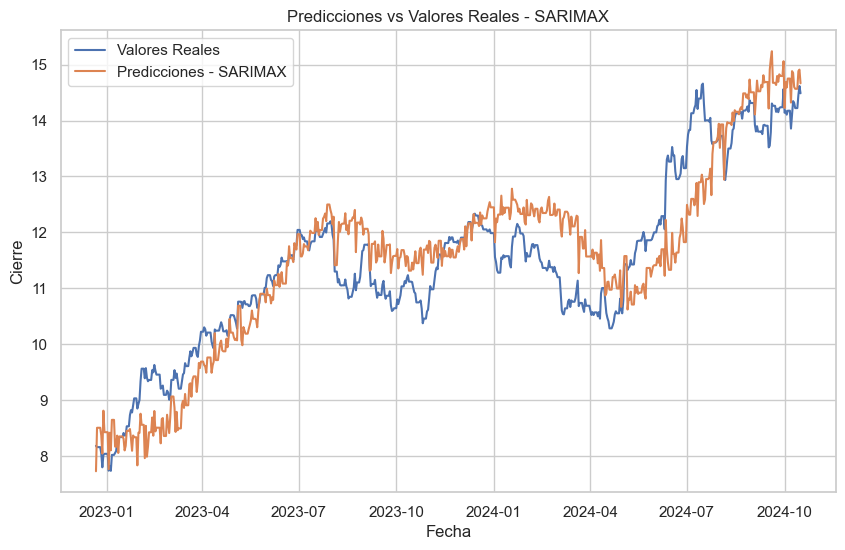

In [80]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Supongamos que ya tienes los datos preprocesados (train_adjusted y validation_adjusted) con variables exógenas
# Ejemplo de variables exógenas
exog_columns = ['log_return', 'volatility', 'ma50', 'ma100', 'volume_to_price']
exog_train = train_adjusted[exog_columns]
exog_validation = validation_adjusted[exog_columns]

# Ajustamos el índice de los datos de entrenamiento y validación
train_adjusted.index = pd.to_datetime(train_adjusted.index)
validation_adjusted.index = pd.to_datetime(validation_adjusted.index)

# Aplicamos auto_arima para optimizar los parámetros p, d, q, P, D, Q, m
stepwise_model = auto_arima(
    y=train_adjusted['close'],
    exogenous=exog_train,
    start_p=0, start_q=0, max_p=3, max_q=3, 
    start_P=0, start_Q=0, max_P=2, max_Q=2, 
    m=12,  # Estacionalidad anual, asumiendo datos mensuales
    seasonal=True, 
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True,
    stepwise=True
)

# Resumen del modelo seleccionado por auto_arima
print(stepwise_model.summary())

# Paso 3: Entrenar SARIMAX con los hiperparámetros óptimos encontrados
model_sarimax = SARIMAX(
    train_adjusted['close'],
    exog=exog_train,
    order=stepwise_model.order, 
    seasonal_order=stepwise_model.seasonal_order
)

# Ajustar el modelo
sarimax_fitted = model_sarimax.fit(disp=False)

# Paso 4: Predecir usando el modelo ajustado
y_pred_sarimax = sarimax_fitted.predict(
    start=validation_adjusted.index[0], 
    end=validation_adjusted.index[-1], 
    exog=exog_validation
)

# Evaluación del modelo
mae_sarimax = mean_absolute_error(validation_adjusted['close'], y_pred_sarimax)
rmse_sarimax = np.sqrt(mean_squared_error(validation_adjusted['close'], y_pred_sarimax))
print(f"SARIMAX - MAE: {mae_sarimax}, RMSE: {rmse_sarimax}")

# Paso 5: Visualización de las predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.plot(validation_adjusted.index, validation_adjusted['close'], label='Valores Reales')
plt.plot(validation_adjusted.index, y_pred_sarimax, label='Predicciones - SARIMAX')
plt.title('Predicciones vs Valores Reales - SARIMAX')
plt.xlabel('Fecha')
plt.ylabel('Cierre')
plt.legend()
plt.show()


c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\danny\OneDrive\Escritorio\bitcoin-vs-gold\.conda\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMAX Ajustado - MAE: 0.6047090383198382, RMSE: 0.7416587204053597


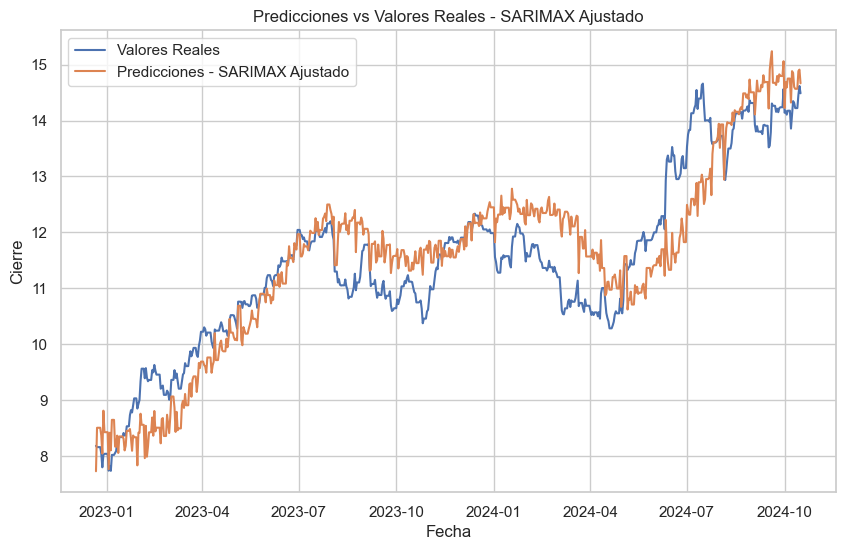

In [81]:
# Reentrenar SARIMAX con ajuste de número de iteraciones y pruebas con hiperparámetros diferentes
model_sarimax_ajustado = SARIMAX(
    train_adjusted['close'], 
    exog=exog_train,  # Usando variables exógenas ajustadas
    order=(0, 1, 0), 
    seasonal_order=(0, 0, 0, 12),
    maxiter=1000,  # Incrementar el número de iteraciones
    enforce_stationarity=False, 
    enforce_invertibility=False
)

# Ajustar el modelo
sarimax_fitted_ajustado = model_sarimax_ajustado.fit(disp=False)

# Predecir usando el modelo ajustado
y_pred_sarimax_ajustado = sarimax_fitted_ajustado.predict(
    start=validation_adjusted.index[0], 
    end=validation_adjusted.index[-1], 
    exog=exog_validation
)

# Evaluar el modelo ajustado
mae_sarimax_ajustado = mean_absolute_error(validation_adjusted['close'], y_pred_sarimax_ajustado)
rmse_sarimax_ajustado = np.sqrt(mean_squared_error(validation_adjusted['close'], y_pred_sarimax_ajustado))

print(f"SARIMAX Ajustado - MAE: {mae_sarimax_ajustado}, RMSE: {rmse_sarimax_ajustado}")

# Visualización del nuevo modelo ajustado
plt.figure(figsize=(10, 6))
plt.plot(validation_adjusted.index, validation_adjusted['close'], label='Valores Reales')
plt.plot(validation_adjusted.index, y_pred_sarimax_ajustado, label='Predicciones - SARIMAX Ajustado')
plt.title('Predicciones vs Valores Reales - SARIMAX Ajustado')
plt.xlabel('Fecha')
plt.ylabel('Cierre')
plt.legend()
plt.show()


In [ ]:
per = apple.info['trailingPE']
print(f"El PER de Apple es: {per}")

market_cap = apple.info['marketCap']
print(f"La capitalización bursátil de Apple es: {market_cap}")

## Youtube video, en el cual realiza machine learning sobre el sp500

In [ ]:
apple_data.index


In [ ]:
apple_data.plot.line(y="close", use_index=True)

In [40]:
del apple_data["dividends"]
del apple_data["stock_splits"]
# las eliminamos porque no las vamos a usar

In [41]:
apple_data["tomorrow"]=  apple_data["close"].shift(-1)

In [ ]:
apple_data

In [43]:
apple_data["target"] = (apple_data["tomorrow"] > apple_data["close"]).astype(int)

In [ ]:
apple_data

In [ ]:
apple_data.columns

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Separamos los datos en entrenamiento y prueba
train = apple_data.iloc[:-100]
test= apple_data.iloc[-100:]
predictors = ["close", "volume", "open", "high", "low"]
model.fit(train[predictors], train["target"])

In [47]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [48]:
preds  = pd.Series(preds, index= test.index)

In [ ]:
precision_score(test["target"], preds)

In [50]:
combined = pd.concat([test["target"], preds], axis=1)

In [ ]:
combined.plot()

In [52]:
##backtesting
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index= test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

In [53]:
def backtest(data, model, predictors, start= 2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)


In [54]:
predictions = backtest(apple_data, model, predictors)

In [ ]:
predictions["predictions"].value_counts()

In [ ]:
precision_score(predictions["target"]), predictions["predictions"]

In [ ]:
predictions["target"].value_counts() /predictions.shape[0]

In [33]:
horizons = [2,5,60,250,1000]

new_predictions =[]

for horizon in horizons:

    rolling_averages = apple_data.rolling(horizon).mean()

    ratio_column = f"Close_ratio_{horizon}"
    apple_data[ratio_column] = apple_data["close"] / rolling_averages["close"]

    trend_column = f"Trend_{horizon}"
    apple_data[trend_column] = apple_data.shift(1).rolling(horizon).sum()["target"]

    new_predictions += [ratio_column, trend_column]

In [ ]:
apple_data = apple_data.dropna()
apple_data